In [2]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [1]:
import os 
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..') # 
elif not pathlib.Path('models').exists():
  !git clone https://github.com/tensorflow/models
  %cd models
  !git reset --hard d7ce106b8ea449cc629569ca43a95e55a18807fa  
  %cd ..

In [ ]:
import subprocess
import shutil

# 이동

os.chdir(r"C:\Users\jungsu1\Desktop\Object detction model\models\research")

# .proto 파일 컴파일
subprocess.run("protoc object_detection/protos/*.proto --python_out=.", shell=True)

# setup.py 복사
subprocess.run("cp object_detection/packages/tf2/setup.py .", shell=True)

# 패키지 설치
subprocess.run("python -m pip install .", shell=True)

In [3]:
def load_image_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))

  if image.mode != 'RGB':
        image = image.convert('RGB')
        
  (im_width, im_height) = image.size
  
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [6]:
input_image = r"C:\Users\jungsu1\Desktop\Object_detction_model\models\research\object_detection\test_images\image1.jpg"

load_image_numpy_array(input_image)

array([[[ 53,  39,  26],
        [ 40,  26,  15],
        [ 27,  13,   4],
        ...,
        [233, 221, 199],
        [234, 222, 200],
        [234, 222, 200]],

       [[ 52,  38,  27],
        [ 41,  27,  16],
        [ 31,  17,   8],
        ...,
        [231, 219, 197],
        [231, 219, 197],
        [231, 219, 197]],

       [[ 49,  37,  25],
        [ 43,  29,  20],
        [ 38,  24,  15],
        ...,
        [228, 216, 194],
        [228, 216, 194],
        [228, 216, 194]],

       ...,

       [[ 66,  65,  79],
        [ 64,  63,  77],
        [ 64,  63,  77],
        ...,
        [100, 102, 123],
        [ 92,  96, 121],
        [ 91,  97, 123]],

       [[ 72,  72,  82],
        [ 71,  71,  81],
        [ 68,  68,  78],
        ...,
        [101, 103, 124],
        [ 97, 101, 126],
        [102, 108, 134]],

       [[ 77,  78,  83],
        [ 78,  79,  84],
        [ 75,  76,  81],
        ...,
        [ 98, 100, 123],
        [ 95,  99, 124],
        [101, 107, 133]]

In [7]:
model_name = 'faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8'

In [8]:
# config 파일과 checkpoint 파일의 경로를 설정합니다.
pipeline_config = os.path.join('models/research/object_detection/configs/tf2/', model_name + '.config')
model_dir = 'models/research/object_detection/test_data/checkpoint/'

# config파일을 이용해서 모델 인스턴스를 생성합니다.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# checkpoint 파일로부터 파라미터를 복원합니다.
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

# model의 예측 결과를 받아옵니다.
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [12]:
# ms coco 레이블들을 읽어옵니다.
LABEL_MAP_PATH = 'models/research/object_detection/data/mscoco_label_map.pbtxt'

label_map_path = LABEL_MAP_PATH
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [9]:
%matplotlib inline

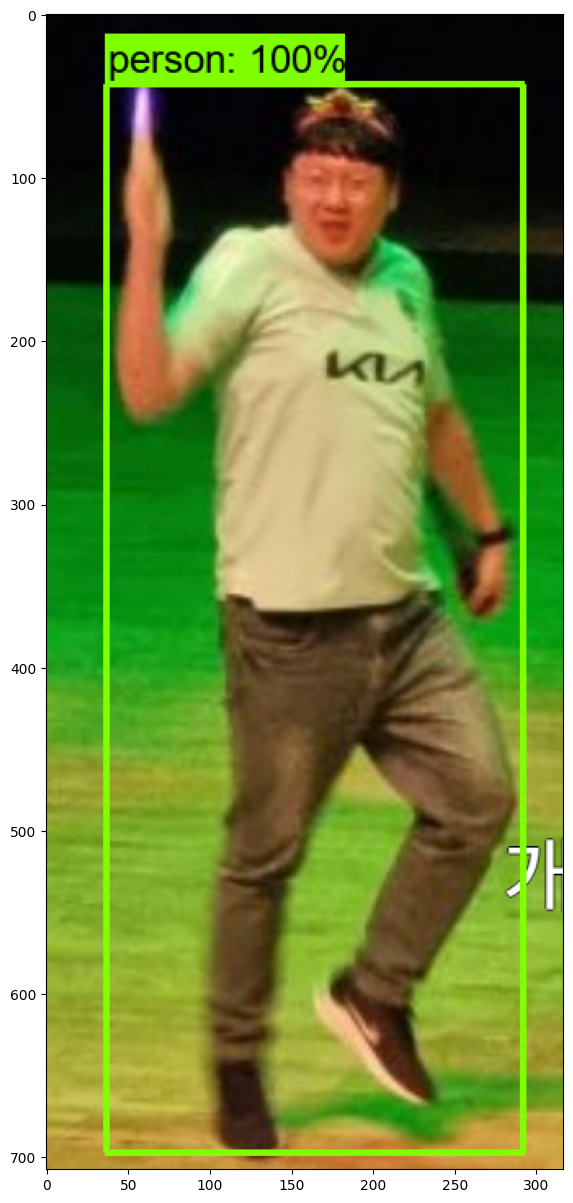

In [13]:
# 이미지 파일 경로에서 테스트 이미지를 np.array 형태로 읽어옵니다.
image_dir = 'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'han.png')
image_np = load_image_numpy_array(image_path)

# 이미지에 대한 예측을 수행합니다.
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# image_np_with_detections np.array에 시각화 결과를 반환합니다.
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.80,
      agnostic_mode=False
      )

plt.figure(figsize=(15, 15))
plt.imshow(image_np_with_detections)
plt.show()